In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sn #Plots
import matplotlib.pyplot as plt
import os
print(os.listdir("../input")) #Files

#models and proccesing
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

['2017AllStarGame.csv', 'tabla_nba2018.csv', '2016AllStarGame.csv', 'tabla_nba2017.csv', '2018AllStarGame.csv', 'tabla_nba2016.csv']


In [2]:
# Players statistics from 2016-2018
data2016 = pd.read_csv("../input/tabla_nba2016.csv")
All2016 = pd.read_csv("../input/2016AllStarGame.csv", sep= ';')

data2017 = pd.read_csv("../input/tabla_nba2017.csv")
All2017 = pd.read_csv("../input/2017AllStarGame.csv", sep= ';')
# The players selection method changed after 2017. 
data2018 = pd.read_csv("../input/tabla_nba2018.csv")
All2018 = pd.read_csv("../input/2018AllStarGame.csv", sep= ';')

In [3]:
#drop of duplicated and features that wont be used.
drops = ['Unnamed: 0','Ranking_x.1','Team_x.1','Games_y','Games_x.1','ReboundsxGame','Reboundsx48min',
         'MinutesxGame_x.1','TurnoversxGame_x', 'Assistsx48min','Ranking_y.1', 'Team_y.1', 'Games_y.1',
         'MinutesxGame_y.1','BlockxGame','Blockx48min', 'BlockxFoul', 'Ranking_x.2', 'Team_x.2', 
         'Games_x.2','MinutesxGame_x.2','StealsxGame', 'Stealsx48min','Turnovers_y', 'TurnoversxGame_y',
         'PersonalFouls_y','StealsxTurnover','StealsxFoul', 'Ranking_y.2', 'Team_y.2', 'Games_y.2',
         'MinutesxGame_y.2','PersonalFoulsxGame','PersonalFoulsx48min','Ranking_y','Team_y', 
         'MinutesxGame_y','FieldGoalsxGame','AssistsxGame','AssistxTurnover','PersonalFouls_x',
         'OffensiveReboundsxGame','DefensiveReboundsxGame', 'Ranking_x']

In [4]:
#preproccesing for each pair of datasets
def sepandrep(dataset,dataset2, droplist, year):
    #drops
    dataset.drop(columns = droplist  ,inplace= True)
    #split data
    divide = pd.DataFrame(dataset["Player"].str.split(',',expand=True))
    divide.columns=["Player","Position"]
    divide2 = pd.DataFrame(dataset["3Pointers"].str.split('-',expand=True))
    divide2.columns=["3Pointersmin","3Pointersmax"]
    divide3 = pd.DataFrame(dataset["FreeTrows"].str.split('-',expand=True))
    divide3.columns=["FreeTrowsmin","FreeTrowsmax"]
    #Adding split data to the dataset
    dataset["Position"] = divide["Position"]
    dataset["Player"] = divide["Player"]
    dataset["3Pointersmin"] = divide2["3Pointersmin"].astype(float)
    dataset["3Pointersmax"] = divide2["3Pointersmax"].astype(float)
    dataset["FreeTrowsmin"] = divide3["FreeTrowsmin"].astype(float)
    dataset["FreeTrowsmax"] = divide3["FreeTrowsmax"].astype(float)
    #New Features
    dataset["3Pointers"] = (dataset["3Pointersmin"] + dataset["3Pointersmax"])/2
    dataset["FreeTrows"] = (dataset["FreeTrowsmin"] + dataset["FreeTrowsmax"])/2
    #Target
    dataset.loc[dataset['Player'].isin(dataset2['Player']),'AllStars'] = 1
    dataset.loc[dataset['Player'].isin(dataset2['Player']) & dataset2['Starter'] == 1,'Starter'] = 1
    #Filling NaN values, this values correspond to 0s and not to missing data.
    dataset.fillna(0, inplace= True)
    #New feature
    dataset['year'] = year

In [5]:
sepandrep(data2016, All2016, drops, 2016)
sepandrep(data2017, All2017, drops, 2017)
sepandrep(data2018, All2018, drops, 2018)

In [6]:
#Merging 2016, 2017 and 2018 datasets.
data = pd.concat([data2016,data2017,data2018])
data.shape

(1368, 29)

In [7]:
#Features used for the model
data.columns

Index(['Player', 'Team_x', 'Games_x', 'MinutesxGame_x', 'PointsxGame',
       'FieldGoalPercentage', '3Pointers', '3pointersPercentage', 'FreeTrows',
       'FTPercentage', 'OffensiveRebounds', 'DefensiveRebounds', 'Rebounds',
       'Assists', 'Turnovers_x', 'Blocks', 'Steals', 'PersonalFouls',
       'FlagrantFouls', 'TechnicalFouls', 'Ejections', 'Position',
       '3Pointersmin', '3Pointersmax', 'FreeTrowsmin', 'FreeTrowsmax',
       'AllStars', 'Starter', 'year'],
      dtype='object')

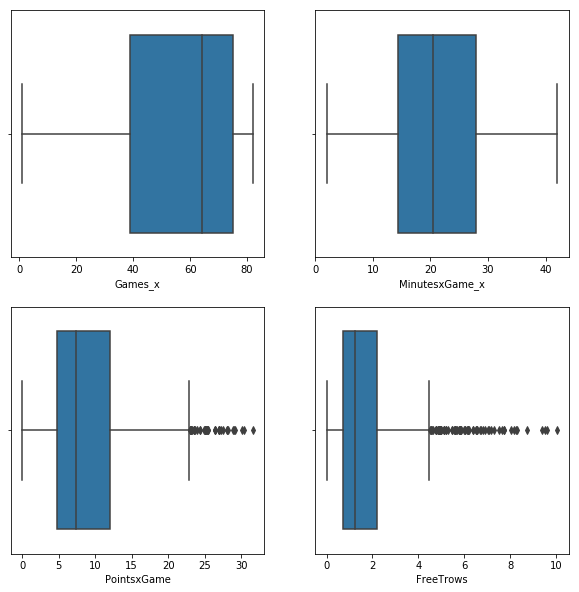

In [8]:
#Some visualizations for numerical variables
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sn.boxplot(data['Games_x'],ax=ax1)
sn.boxplot(data['MinutesxGame_x'],ax=ax2)
sn.boxplot(data['PointsxGame'],ax=ax3)
sn.boxplot(data['FreeTrows'],ax=ax4)

plt.show()

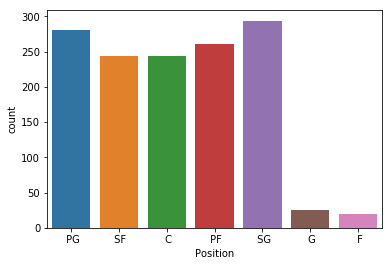

In [9]:
# players positions
# some categories dont seem to be well defined
sn.countplot(data['Position'])

In [10]:
#Dummies and merge
z = pd.get_dummies(data.Position)
frames = [data, z]
datafinal = pd.concat(frames, axis=1)
print(data.shape)

(1368, 29)


In [11]:
#Train and test data
train = datafinal[(datafinal['year'] == 2016) | (datafinal['year'] == 2017)]
test = datafinal[(datafinal['year'] == 2017)]
print(train.shape)
print(test.shape)

(946, 36)
(470, 36)


In [12]:
#selection of data
X_train = train.drop(columns=['Player', 'Team_x', 'AllStars', 'Starter', 'Position'])
y_train = train['AllStars']

X_test = test.drop(columns=['Player', 'Team_x', 'AllStars', 'Starter', 'Position'])
y_test = test['AllStars']

In [13]:
#Normalization
X_train = preprocessing.scale(X_train, axis = 0)
X_test = preprocessing.scale(X_test, axis = 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#Random Forest

param_trees = {'n_estimators': [100, 200],
               'max_features': [2, 5, 7, 10, 15, 20, 25],
               'max_depth': [2, 3, 4, 6, 8, 10], 
               'min_samples_leaf':[2, 5, 7, 10, 15],
               'random_state': [0]}

rf = RandomForestClassifier()
rfgrid = GridSearchCV(rf, param_grid=param_trees, cv=3, verbose=1, n_jobs=-1)
rfgrid.fit(X_train, y_train)

print(rfgrid.best_params_)
print(rfgrid.best_score_)

y_pred = rfgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 420 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:  2.6min finished


{'max_depth': 2, 'max_features': 20, 'min_samples_leaf': 15, 'n_estimators': 100, 'random_state': 0}
0.9661733615221987
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       445
         1.0       0.73      0.76      0.75        25

   micro avg       0.97      0.97      0.97       470
   macro avg       0.86      0.87      0.87       470
weighted avg       0.97      0.97      0.97       470



In [15]:
#Gradient Booster

param_bost = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.1, 0.3, 0.5],
               'max_features': [2, 5, 7, 10, 15, 20, 25, 30],
               'max_depth': [2, 3, 4, 6, 8, 10], 
               'min_samples_leaf':[2, 5, 7, 10, 15],
               'random_state': [0]}

gb = GradientBoostingClassifier()
gbgrid = GridSearchCV(gb, param_grid=param_bost, cv=3, verbose=1, n_jobs=-1)
gbgrid.fit(X_train, y_train)

print(gbgrid.best_params_)
print(gbgrid.best_score_)

y_pred = gbgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3346 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4096 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4946 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 5896 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  5.8min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will chan

{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 20, 'min_samples_leaf': 15, 'n_estimators': 100, 'random_state': 0}
0.96723044397463
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       445
         1.0       1.00      0.84      0.91        25

   micro avg       0.99      0.99      0.99       470
   macro avg       1.00      0.92      0.95       470
weighted avg       0.99      0.99      0.99       470



In [16]:
#xgb

param_xgb = {'eta': [0.1, 0.3, 0.5],
             'max_depth': [2, 3, 4, 6, 8],
             'n_estimators': [100, 200, 300, 600],
             'min_child_weight': [1, 5, 10],
             'colsample_bytree': [0.6, 0.8, 1.0]}

xgb = XGBClassifier()
xgbgrid = GridSearchCV(xgb, param_grid=param_xgb, cv=3, verbose=1, n_jobs=-1)
xgbgrid.fit(X_train, y_train)

print(xgbgrid.best_params_)
print(xgbgrid.best_score_)

y_pred = xgbgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  2.1min finished


{'colsample_bytree': 0.6, 'eta': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 200}
0.9651162790697675
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       445
         1.0       0.92      0.92      0.92        25

   micro avg       0.99      0.99      0.99       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.99      0.99      0.99       470



In [17]:
#Voting for xgb and gradient booster models
#We select the models with their parameters.
xgb = XGBClassifier(colsample_bytree = 0.6, eta = 0.1, max_depth = 2, min_child_weight = 5, n_estimators = 200)
gb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 8, max_features = 20, min_samples_leaf = 15, n_estimators = 100, 
                                random_state = 0)

vote = VotingClassifier(estimators=[('xgb', xgb), ('gb', gb)],voting='soft')
vote.fit(X_train, y_train)

y_pred_vote = vote.predict(X_test)
print(classification_report(y_test, y_pred_vote))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       445
         1.0       1.00      0.92      0.96        25

   micro avg       1.00      1.00      1.00       470
   macro avg       1.00      0.96      0.98       470
weighted avg       1.00      1.00      1.00       470



![](http://)Voting with both models improve both recall and f1.

In [18]:
#Players in AllStars 2018
results = pd.DataFrame(test['Player'][test['AllStars'] == 1].sort_values())
results['Predicted'] = test['Player'][y_pred_vote == 1].sort_values()
print(results)

                    Player              Predicted
3            Anthony Davis          Anthony Davis
21         Carmelo Anthony        Carmelo Anthony
101         DeAndre Jordan                    NaN
4            DeMar DeRozan          DeMar DeRozan
6         DeMarcus Cousins       DeMarcus Cousins
142         Draymond Green         Draymond Green
20   Giannis Antetokounmpo  Giannis Antetokounmpo
25          Gordon Hayward         Gordon Hayward
2            Isaiah Thomas          Isaiah Thomas
1             James Harden           James Harden
13            Jimmy Butler           Jimmy Butler
17               John Wall              John Wall
8            Kawhi Leonard          Kawhi Leonard
16            Kemba Walker           Kemba Walker
12            Kevin Durant           Kevin Durant
35              Kevin Love             Kevin Love
23           Klay Thompson          Klay Thompson
22              Kyle Lowry             Kyle Lowry
10            Kyrie Irving           Kyrie Irving


We can see that all players predicted went to AllStars 2018, but there are 2 missing players in the prediction. Of a total of 25 players, 23 were predicted.

         Prob                 Player  Preds  Real
6    0.992843       DeMarcus Cousins    1.0   1.0
13   0.988162           Jimmy Butler    1.0   1.0
1    0.987832           James Harden    1.0   1.0
8    0.984830          Kawhi Leonard    1.0   1.0
0    0.981597      Russell Westbrook    1.0   1.0
12   0.977896           Kevin Durant    1.0   1.0
7    0.977099           LeBron James    1.0   1.0
20   0.976526  Giannis Antetokounmpo    1.0   1.0
14   0.976498            Paul George    1.0   1.0
9    0.971585          Stephen Curry    1.0   1.0
3    0.961901          Anthony Davis    1.0   1.0
17   0.952672              John Wall    1.0   1.0
33   0.934679             Marc Gasol    1.0   1.0
21   0.920661        Carmelo Anthony    1.0   1.0
10   0.915104           Kyrie Irving    1.0   1.0
4    0.877214          DeMar DeRozan    1.0   1.0
22   0.876367             Kyle Lowry    1.0   1.0
35   0.854885             Kevin Love    1.0   1.0
23   0.811181          Klay Thompson    1.0   1.0


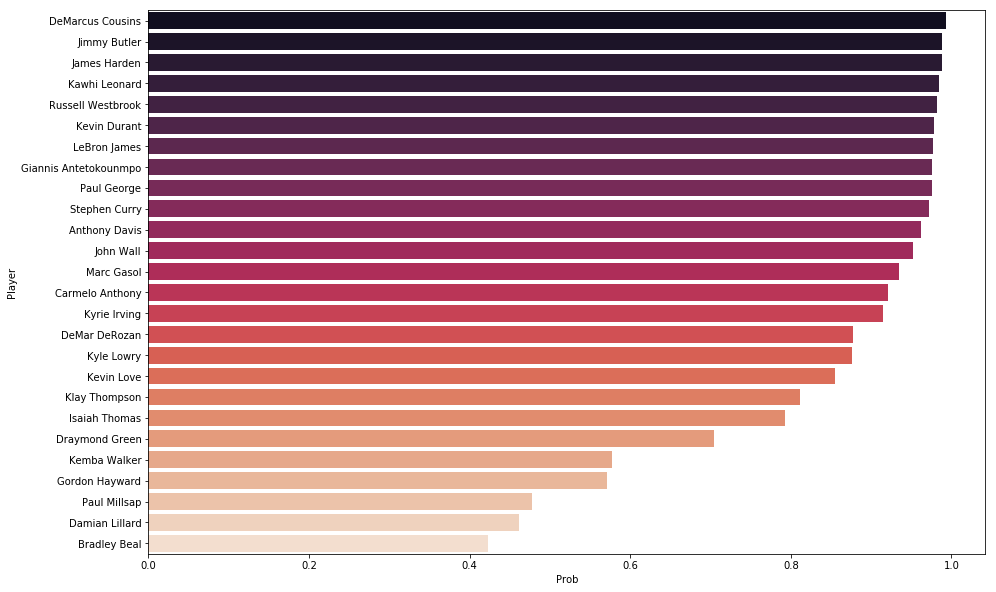

In [20]:
probs = pd.DataFrame()
predprob = vote.predict_proba(X_test)
probs['Prob'] = predprob[:,1]
probs['Player'] = test['Player']
probs['Preds'] = vote.predict(X_test)
probs['Real'] = test['AllStars']
probs.sort_values(by='Prob', inplace=True, ascending=False)

print(probs[probs['Real'] == 1])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot()
sn.barplot(x=probs['Prob'][:26], y=probs['Player'][:26], palette="rocket", ax=ax1)

In [ ]:
#We can see that Paul Millsap probability was close to the selection, but DeAndre Jordan probability was low.
#We may find why if we compare his statistics with the predicted targets.
#Since this model is only based on statistics, the player popularity and general expactations could make a difference.

In [21]:
import pickle

#serializing our model to a file called modelNBA.pkl
pickle.dump(vote, open("modelNBA.pkl","wb"))